[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/obss/sahi/blob/main/demo/inference_for_sparse_yolov5.ipynb)

## 0. Preperation

- Install latest version of SAHI and DeepSparse:

In [ ]:
pip install sahi

In [ ]:
%%bash 
git clone https://github.com/neuralmagic/deepsparse.git
cd deepsparse
python setup.py install

- Import required modules:

In [ ]:
pip install sparseml[torch,torchvision]

In [ ]:
pip install fiftyone imantics

In [ ]:
pip install --upgrade numpy

In [2]:
# import required functions, classes
from sahi import AutoDetectionModel
from sahi.utils.cv import read_image
from sahi.utils.file import download_from_url
from sahi.predict import get_prediction, get_sliced_prediction, predict
from IPython.display import Image

- Download a yolov5 model and two test images:

In [3]:
# download test images into demo_data folder
download_from_url('https://raw.githubusercontent.com/obss/sahi/main/demo/demo_data/small-vehicles1.jpeg', 'demo_data/small-vehicles1.jpeg')
download_from_url('https://raw.githubusercontent.com/obss/sahi/main/demo/demo_data/terrain2.png', 'demo_data/terrain2.png')

## 1. Standard Inference with a YOLOv5 Model

- Instantiate a detection model by defining model weight path and other parameters:

In [43]:
model_path = "zoo:cv/detection/yolov5-s/pytorch/ultralytics/coco/pruned-aggressive_96"
detection_model = AutoDetectionModel.from_pretrained(
    model_type='yolov5sparse',
    confidence_threshold=0.3,
    image_size = 640,
    model_path = model_path ,
    device="cpu", # or 'cuda:0'
)

- Perform prediction by feeding the get_prediction function with an image path and a DetectionModel instance:

In [44]:
result = get_prediction("demo_data/small-vehicles1.jpeg", detection_model)

In [45]:
result.object_prediction_list[0]

ObjectPrediction<
    bbox: BoundingBox: <(321.6000506401062, 322.65680503845215, 384.68315992355343, 362.83818435668945), w: 63.08310928344724, h: 40.181379318237305>,
    mask: None,
    score: PredictionScore: <value: 0.8379215002059937>,
    category: Category: <id: 2, name: car>>

- Or perform prediction by feeding the get_prediction function with a numpy image and a DetectionModel instance:

In [46]:
result = get_prediction(read_image("demo_data/small-vehicles1.jpeg"), detection_model)

- Visualize predicted bounding boxes and masks over the original image:

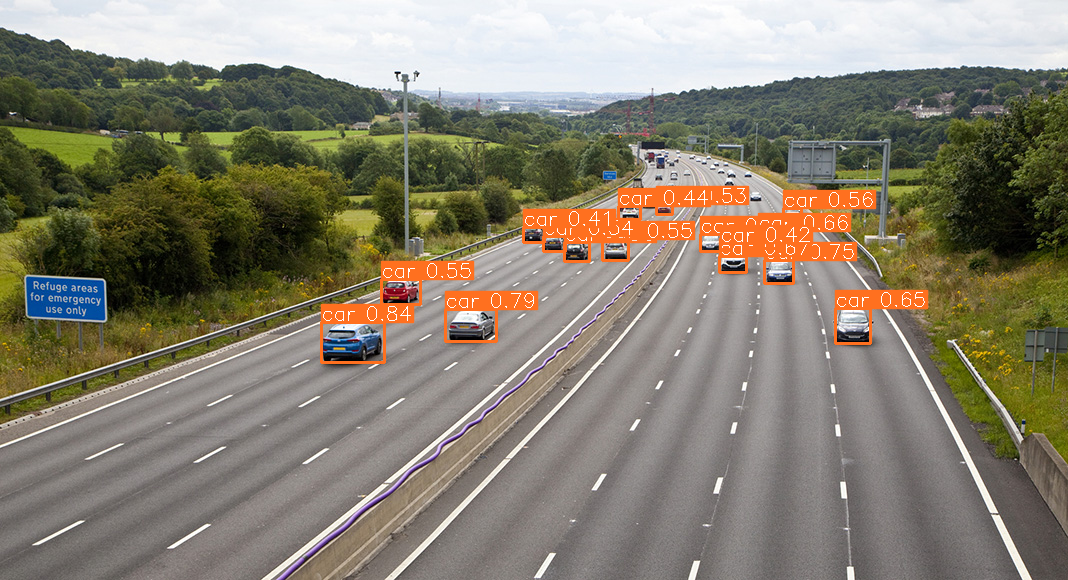

In [47]:
result.export_visuals(export_dir="demo_data/")

Image("demo_data/prediction_visual.png")

## 2. Sliced Inference with a YOLOv5 Model and DeepSparse

[DeepSparse](https://neuralmagic.com/deepsparse/) is an inference runtime offering GPU-class performance on CPUs and APIs to integrate ML into your application. Sparsification is a powerful technique for optimizing models for inference, reducing the compute needed with a limited accuracy tradeoff.

DeepSparse is designed to take advantage of model sparsity, enabling you to deploy models with the flexibility and scalability of software on commodity CPUs with the best-in-class performance of hardware accelerators, enabling you to standardize operations and reduce infrastructure costs.

Similar to Hugging Face, DeepSparse provides off-the-shelf pipelines for computer vision and NLP that wrap the model with proper pre- and post-processing to run performantly on CPUs by using sparse models.

- To perform sliced prediction we need to specify slice parameters. In this example we will perform prediction over slices of 256x256 with an overlap ratio of 0.2:

In [48]:
result = get_sliced_prediction(
    "demo_data/small-vehicles1.jpeg",
    detection_model,
    slice_height = 256,
    slice_width = 256,
    overlap_height_ratio = 0.2,
    overlap_width_ratio = 0.2
)

Performing prediction on 15 number of slices.


- Visualize predicted bounding boxes and masks over the original image:

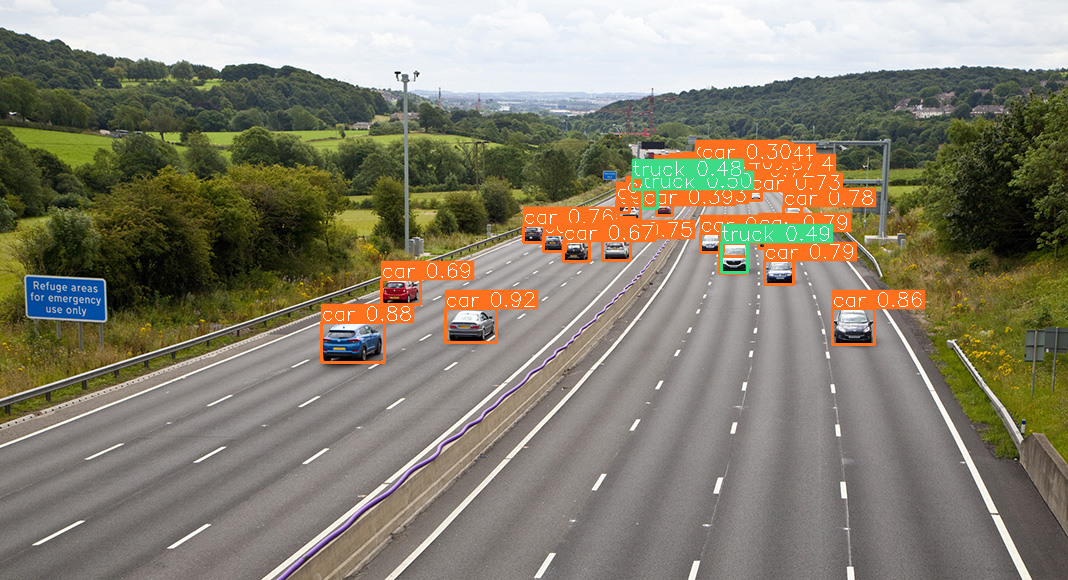

In [49]:
result.export_visuals(export_dir="demo_data/")

Image("demo_data/prediction_visual.png")

## 3. Prediction Result

- Predictions are returned as [sahi.prediction.PredictionResult](sahi/prediction.py), you can access the object prediction list as:

In [41]:
object_prediction_list = result.object_prediction_list

In [42]:
object_prediction_list[0]

ObjectPrediction<
    bbox: BoundingBox: <(445.2277250289917, 308.79749755859376, 496.7115755081177, 342.3387817382812), w: 51.48385047912598, h: 33.541284179687466>,
    mask: None,
    score: PredictionScore: <value: 0.9191004633903503>,
    category: Category: <id: 2, name: car>>

- ObjectPrediction's can be converted to [COCO annotation](https://cocodataset.org/#format-data) format:

In [17]:
result.to_coco_annotations()[:3]

[{'image_id': None,
  'bbox': [445.2277250289917,
   308.79749755859376,
   51.48385047912598,
   33.541284179687466],
  'score': 0.9191004633903503,
  'category_id': 2,
  'category_name': 'car',
  'segmentation': [],
  'iscrowd': 0,
  'area': 1726},
 {'image_id': None,
  'bbox': [321.6000506401062,
   322.209326171875,
   63.08310928344724,
   40.759497070312534],
  'score': 0.8783385753631592,
  'category_id': 2,
  'category_name': 'car',
  'segmentation': [],
  'iscrowd': 0,
  'area': 2571},
 {'image_id': None,
  'bbox': [832.6520904541015,
   308.5481811523438,
   41.710104370117165,
   36.04396057128906],
  'score': 0.8638250827789307,
  'category_id': 2,
  'category_name': 'car',
  'segmentation': [],
  'iscrowd': 0,
  'area': 1503}]

- ObjectPrediction's can be converted to [COCO prediction](https://github.com/i008/COCO-dataset-explorer) format:

In [18]:
result.to_coco_predictions(image_id=1)[:3]

[{'image_id': 1,
  'bbox': [445.2277250289917,
   308.79749755859376,
   51.48385047912598,
   33.541284179687466],
  'score': 0.9191004633903503,
  'category_id': 2,
  'category_name': 'car',
  'segmentation': [],
  'iscrowd': 0,
  'area': 1726},
 {'image_id': 1,
  'bbox': [321.6000506401062,
   322.209326171875,
   63.08310928344724,
   40.759497070312534],
  'score': 0.8783385753631592,
  'category_id': 2,
  'category_name': 'car',
  'segmentation': [],
  'iscrowd': 0,
  'area': 2571},
 {'image_id': 1,
  'bbox': [832.6520904541015,
   308.5481811523438,
   41.710104370117165,
   36.04396057128906],
  'score': 0.8638250827789307,
  'category_id': 2,
  'category_name': 'car',
  'segmentation': [],
  'iscrowd': 0,
  'area': 1503}]

- ObjectPrediction's can be converted to [imantics](https://github.com/jsbroks/imantics) annotation format:

In [23]:
result.to_imantics_annotations()[:3]

- ObjectPrediction's can be converted to [fiftyone](https://github.com/voxel51/fiftyone) detection format:

In [27]:
result.to_fiftyone_detections()[:3]

Migrating database to v0.19.1


INFO:fiftyone.migrations.runner:Migrating database to v0.19.1


[<Detection: {
     'id': '640f53c4ef2501d34f72f807',
     'attributes': {},
     'tags': [],
     'label': 'car',
     'bounding_box': [
         0.41687989234924316,
         0.5324094785492995,
         0.04820585250854492,
         0.05782980030980597,
     ],
     'mask': None,
     'confidence': 0.9191004633903503,
     'index': None,
 }>, <Detection: {
     'id': '640f53c4ef2501d34f72f808',
     'attributes': {},
     'tags': [],
     'label': 'car',
     'bounding_box': [
         0.3011236429214477,
         0.5555333209859913,
         0.0590665817260742,
         0.07027499494881471,
     ],
     'mask': None,
     'confidence': 0.8783385753631592,
     'index': None,
 }>, <Detection: {
     'id': '640f53c4ef2501d34f72f809',
     'attributes': {},
     'tags': [],
     'label': 'car',
     'bounding_box': [
         0.7796367888147018,
         0.5319796226764548,
         0.03905440484093368,
         0.0621447596056708,
     ],
     'mask': None,
     'confidence': 0.86382

## 4. Batch Prediction

- Set model and directory parameters:

In [32]:
model_type = "yolov5sparse"
model_device = "cpu" # or 'cuda:0'
model_confidence_threshold = 0.4

slice_height = 256
slice_width = 256
overlap_height_ratio = 0.2
overlap_width_ratio = 0.2

source_image_dir = "demo_data/"

- Perform sliced inference on given folder:

In [33]:
predict(
    model_type=model_type,
    model_path=model_path,
    model_device=model_device,
    model_confidence_threshold=model_confidence_threshold,
    source=source_image_dir,
    slice_height=slice_height,
    slice_width=slice_width,
    overlap_height_ratio=overlap_height_ratio,
    overlap_width_ratio=overlap_width_ratio,
)

There are 3 listed files in folder: demo_data/


Performing inference on images:   0%|          | 0/3 [00:00<?, ?it/s]

Performing prediction on 15 number of slices.


Performing inference on images:  33%|███▎      | 1/3 [00:06<00:13,  6.76s/it]

Prediction time is: 6644.16 ms
Performing prediction on 15 number of slices.


Performing inference on images:  67%|██████▋   | 2/3 [00:11<00:05,  5.34s/it]

Prediction time is: 4254.34 ms
Performing prediction on 20 number of slices.


Performing inference on images: 100%|██████████| 3/3 [00:21<00:00,  7.05s/it]

Prediction time is: 9964.91 ms
Prediction results are successfully exported to runs/predict/exp
